## Prisoners Dilemma - working solution

1. Run 10 games between 2 agents, using Tit for Tat strategy - see previous notebook 
2. Run 10 games between 5 agents? 
3. add Q-learning - learn the dominant strategy 
4. How to add something like social norm or morality to this? 
	a. Add a player caring about how many years another player spends in jail 
	b. Add trust? 
    c. Add player fearing retribution for confessing and testifying 
    


### 1. Run 10 games between 2 agents, using Q-Learning to learn optimal strategy

code based on https://subversion.american.edu/aisaac/notes/pdsim.htm

In [157]:
import random 
import itertools 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

 Define helper functions:

In [158]:
def get_random_pairs(mylist): 
  # Generate all possible non-repeating pairs 
  pairs = list(itertools.combinations(mylist, 2)) 
 
  # Randomly shuffle these pairs 
  random.shuffle(pairs) 
  return pairs 

def mean(seq):  #simplest computation of mean
    """Return mean of values in `seq`."""
    n = len(seq)
    return sum(seq)/float(n)

def transpose(seqseq): #simple 2-dimensional transpose
    """Return transpose of `seqseq`."""
    return zip(*seqseq)

We wil be using two objects (classes) - a Game and a Player: 

Game
- Data: players, payoffmat, history, opponents
- Methods: run, payoff

Player
- Data: playertype, games_player, players_played
- Methods: get_last_move, make_own_move, record, reset

An action is selected between “defection” (represented by True or integer 1) or “cooperation” (represented by False or integer 0). 

The table below illustrates the resulting interdependencies between objects when a game asks a player for a move. As part of selecting a move, the player first fetches the opponent's last move from the game. Once the player has this last move, it computes a move and returns it to the game that asked for it.

|                Game               |              Player                       |
|:---------------------------------:|:-----------------------------------------:|
| 1. request move from Player       |                                           |                                 |
|                                   | 2. start generating move                  |                                 |
|                                   | 3. request opponent's last move           |
|                                   | 4. compute opponent's last move by looking into the Game's in history |     |
|                                   | 5. compute new move based on last move + the strategy                      |
|                                   | 6. return new move to Game                |                                 |
| 7. compute payoffs based on pair of moves        |                                           |                                 |

In [159]:
class Game:
    def __init__(self, player1, player2, payoffmat):
        # initialize instance attributes
        self.players = [ player1, player2 ]
        self.payoffmat = payoffmat
        self.history = list() #TO DO make this a circular array / queue instead 
        self.opponents = {player1:player2, player2:player1}
    def run(self, game_iter=4):
        # unpack the two players
        player1, player2 = self.players
        # each iteration, get new moves and append these to history
        for iteration in range(game_iter):
            #request move from player - use methods from the Player object
            newmoves = player1.make_own_move(self), player2.make_own_move(self) 
            self.history.append(newmoves) #append pair of moves to the history attritbute of this game 
        # prompt players to record the game played (i.e., 'self') - ???? 
        player1.record(self); player2.record(self) #use methods from the Player object
    def payoff(self):
        # unpack the two players
        player1, player2 = self.players #note we need to define these again from the __init__ method
        # generate player-payoff pairs for each pair of moves (i.e. for each game iteration)
        payoffs = (self.payoffmat[m1][m2] for (m1,m2) in self.history)
        # transpose to get a payoff sequence for each player
        pay1, pay2 = transpose(payoffs) # ????
        # return a mapping of each player to its mean payoff
        #return { player1:mean(pay1), player2:mean(pay2) }
        return { player1:(pay1), player2:(pay2) }

In [248]:
class Player:
    def __init__(self, strategy):
        self.p_cdi=(0,1,0.5) 
        #a tuple containing: 
        # (p(D) if opponent cooperates, 
        # p(C) if opponent cooperates, 
        # p(D) of defecting in the first move)
        
        # (p(C) if opponent defects, 
        # p(D) if opponent defects, 
        # p(D) of defecting in the first move)
        
        # (p(opposite move to opponent), 
        # p(same move as opponent), 
        # p(D) of defecting in the first move)
        
        self.reset() #defined below
        self.strategy = strategy
    def reset(self): 
        ''' assign empty lists to the player's games_played and players_played attributes. These attributes can 
        provide a player with “memory”, which can be augmented each time the player's record method is called.'''
        self.games_played = list()   #empty list
        self.players_played = list()  #empty list
    def get_last_move(self, game):
        ''' get opponent and learn their last move '''
        opponent = game.opponents[self]
        if game.history: # if history not empty, return prior move of `opponent`
            player_idx = game.players.index(opponent)
            last_move = game.history[-1][player_idx]
        else:
            last_move = None
        return last_move
    def make_own_move(self, game):
        
        if self.strategy == 'random':
            return random.uniform(0,1) < 0.5
        
        else:
            '''respond to opponent's last move using a reactive strategy based on 1 last move of the opponent'''
            last_move = self.get_last_move(game)  
            
            if self.strategy == 'TitForTat': 
                if last_move is None: #if this is the initial move
                    p_defect = self.p_cdi[-1]
                else:
                    p_defect = self.p_cdi[last_move]
                return random.uniform(0,1) < p_defect
        
            elif self.strategy == 'Q-Learning greedy':
                if last_move is None: #if this is the initial move
                    p_defect = self.p_cdi[-1]
                    return random.uniform(0,1) < p_defect
                else:
                    optimal_policy = list(np.argmax(Q_values, axis=1)) 
                    # store optimal action for that state(i.e. opponent's last_move), based on Q-Learning results
                    return optimal_policy[last_move] > 0.5 #return 1 if last_move==True (=defect)
        
    def record(self, game):
        self.games_played.append(game)
        opponent = game.opponents[self]
        self.players_played.append(opponent)


In [236]:
optimal_policy = list(np.argmax(Q_values, axis=1)) 
# store optimal action for that state(i.e. opponent's last_move), based on Q-Learning results

optimal_policy[player1.get_last_move(game)]

0

In [235]:
player1.get_last_move(game)
#opponent cooperated 

False

In [222]:
[0,1,0][player1.get_last_move(game)]

0

In [223]:
list(test)[player1.get_last_move(game)]

0

In [224]:
t1, t2 = transpose(PAYOFFMAT)
t1

((3, 3), (5, 0))

In [225]:
t2

((0, 5), (1, 1))

To run game between 2 agents only

In [249]:
## GAME: CDIGame with SimplePlayer
# create a payoff matrix and two players
PAYOFFMAT = [ [(3,3),(0,5)] , [(5,0),(1,1)] ]
#PAYOFFMAT = [ [(-1,-1),(-3,0)] , [(0,-3),(-2,-2)] ]
player1 = Player(strategy='Q-Learning greedy')
player2 = Player(strategy='random')

# create and run the game
game = Game(player1, player2, PAYOFFMAT)
game.run(10)
# retrieve and print the payoffs
payoffs = game.payoff()
print("Player1 payoff: ", mean(payoffs[player1]))
print("Player2 payoff: ", mean(payoffs[player2]))

Player1 payoff:  1.9
Player2 payoff:  3.4


/Users/lizakarmannaya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [250]:
game.history

[(True, True),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, True),
 (False, True),
 (False, True),
 (False, False)]

Run game between >2 players, a pair at a time:

In [251]:
## GAME: CDIGame with SimplePlayer
# create a payoff matrix and two players 
PAYOFFMAT = [ [(3,3),(0,5)] , [(5,0),(1,1)] ]
#PAYOFFMAT = [ [(-1,-1),(-3,0)] , [(0,-3),(-2,-2)] ]

def run_one_game(player1, player2): 
    game = Game(player1, player2, PAYOFFMAT)
    game.run(10)
    # retrieve and print the payoffs
    payoffs = game.payoff()
    
    print("Player1 payoff: ", mean(payoffs[player1]))
    print("Player2 payoff: ", mean(payoffs[player2]))
    
    return game
    

def run_ipd_n_players(n=2): #default at least two players 
    player_names = []
    for i in range(1,n+1):
        name = 'player' + str(i) 
        player_names.append(name)
    player_objects = [Player(strategy='TitForTat') for name in player_names]
    
    pairs_of_players = get_random_pairs(player_objects)
    
    i=0
    games_history = [] 
    for pair in pairs_of_players: 
        i+=1
        print(f'Game {i} betwen: {pair}')
        game = run_one_game(pair[0], pair[1])
        games_history.append(game)
    
    return games_history

In [252]:
games_history = run_ipd_n_players(n=5)

Game 1 betwen: (<__main__.Player object at 0x7fe4475ee4d0>, <__main__.Player object at 0x7fe4475ee390>)
Player1 payoff:  2.5
Player2 payoff:  2.5
Game 2 betwen: (<__main__.Player object at 0x7fe4475ee4d0>, <__main__.Player object at 0x7fe4475eeed0>)
Player1 payoff:  2.5
Player2 payoff:  2.5
Game 3 betwen: (<__main__.Player object at 0x7fe4475eec90>, <__main__.Player object at 0x7fe4475eeed0>)
Player1 payoff:  2.5
Player2 payoff:  2.5
Game 4 betwen: (<__main__.Player object at 0x7fe4475eec90>, <__main__.Player object at 0x7fe4475ee4d0>)
Player1 payoff:  2.5
Player2 payoff:  2.5
Game 5 betwen: (<__main__.Player object at 0x7fe4475ee390>, <__main__.Player object at 0x7fe4475ee410>)
Player1 payoff:  1.0
Player2 payoff:  1.0
Game 6 betwen: (<__main__.Player object at 0x7fe4475eec90>, <__main__.Player object at 0x7fe4475ee410>)
Player1 payoff:  3.0
Player2 payoff:  3.0
Game 7 betwen: (<__main__.Player object at 0x7fe4475eeed0>, <__main__.Player object at 0x7fe4475ee410>)
Player1 payoff:  1.0

In [91]:
dir(games_history[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'history',
 'opponents',
 'payoff',
 'payoffmat',
 'players',
 'run']

## Training the agent with Q-Learning 

1. explore the environment 
2. gradually improve its estimates of Q-values
3. choose optimal policy (e.g. greedy policy with the highest q-value) 

state = (prev own action, prev opponent action).
Therefore we can define one-step markov matrix as four probabilities: P(D'|CC), P(D'|CD), P(D'|DC), P(D'|DD).

reference: https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb

INSTEAD: state = single previous action from the opponent; state 0 = opponent defected in the last move; state 1 = opponent Cooperated in the last move

In [ ]:
#states possible: opponent cooperated; opponent defected in previous move

In [253]:
transition_probabilities = [ # shape=[s, a, s']
#        [[1, 0], [0, 1]],
#        [[1, 0], [0, 1]]]
    
        [[0.5, 0.5], [0.5, 0.5]],
        [[0.5, 0.5], [0.5, 0.5]]]



#[state(=opponent_prev_move), agent_action] = [CC, CD, DC, DD]

#rewards = [ # shape=[s, a, s']
#        [[-1, -1], [-3, 0]],
#        [[0, -3], [-2, -2]]]

rewards = [ # shape=[s, a, s']
    [[3,3], [0,5]], 
    [[5,0], [1,1]]]

possible_actions = [[0, 1], [0, 1]] #C,D

In [101]:
rewards

[[[3, 3], [0, 5]], [[5, 0], [1, 1]]]

In [119]:
def step(state, action):
    '''function to interact with the environment (i.e. the game).
    It takes a state and action as input and computes reward and next state as output.'''
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1], p=probas)
    #next_state = np.random.choice([0, 1])
    reward = rewards[state][action][next_state]
    return next_state, reward

In [120]:
#test that the step function works correctly 
test_next_state, test_reward = step(0,0) #if state (opponent's prev move) = C & my action = D
test_next_state, test_reward

(0, 3)

In [121]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [122]:
for state, actions in enumerate(possible_actions):
    print(f'state: {state}, possible actions: {actions}')

state: 0, possible actions: [0, 1]
state: 1, possible actions: [0, 1]


In [296]:
np.random.seed(42)

Q_values = np.full((2, 2), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.3 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book

for iteration in range(10000):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value) # -Q_values[state, action]) #is the final term needed??
    state = next_state

history2 = np.array(history2) # Not shown

In [297]:
Q_values

array([[27.8184048 , 27.13461633],
       [27.26617522, 25.82949414]])

In [298]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0])

In [290]:
Q_values = np.full((2, 2), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0
    
history1 = [] # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(2):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(2)])

history1 = np.array(history1) # Not shown

In [291]:
history1[-1]

array([[27.59252354, 27.09252354],
       [27.09252354, 25.59252354]])

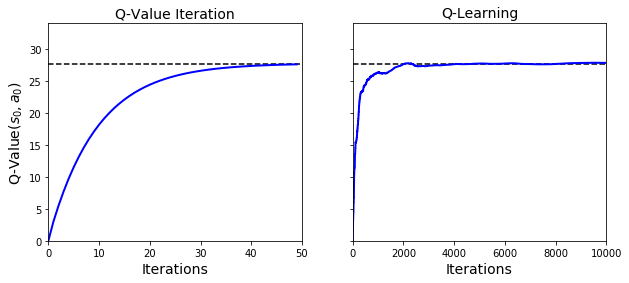

In [292]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 34])

Experimentation showed that alpha=0.05 was too small - it never learnt the true Q-value.  0.1 also never converges to the actual Q-value. I've gone ahead with a learning rate of 0.3 here.